# 2030 분류 모델
- 모델 파일: model/real_final/*

In [1]:
# 라이브러리 import 부분
import pandas as pd
import numpy as np
import re
# 형태소 분류 태그
from konlpy.tag import Okt
import pickle
# 학습-테스트용으로 나누기
from sklearn.model_selection import train_test_split
# 로지스틱회귀로 분류분석 진행하기
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
# 교차검증: 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.
from sklearn.model_selection import StratifiedKFold

# 평가 방법
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 교차검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

## 1. 2030데이터와 언론사 수집 데이터 합치기
- 데이터 수가 너무 많아서 5000개를 사용해서 훈련/테스트 데이터로 분리할 것

In [2]:
# 2030 데이터라고 가정한 데이터
data2030_1 = pd.read_csv('data/data_2030_1.csv', index_col=0)
data2030_2 = pd.read_csv('data/data_2030_2.csv')

# 2030 아닌 데이터
data_1 = pd.read_csv('data/재보궐선거댓글데이터_최종_유튜브수정_0429.csv')
data_2 = pd.read_csv('data/data_candidates.csv')

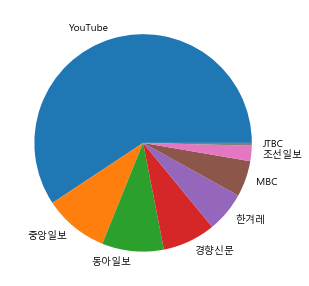

In [3]:
# (참고) 대선 데이터 언론사별 출처 확인 -> Youtube 비중 줄이기 위해 
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['axes.unicode_minus'] = False

plt.pie(data_2['Source'].value_counts(),labels=data_2['Source'].value_counts().index)
plt.show()

In [4]:
# '2030'키워드가 포함된 콘텐츠의 댓글 개수 
data2030_1.shape, data2030_2.shape

((56829, 9), (1173, 9))

In [5]:
# '2030'키워드가 아닌 콘텐츠의 댓글 개수
data_1.shape, data_2.shape

((144139, 11), (158534, 7))

In [6]:
# 2030 데이터를 df1으로 묶기
df1 = pd.concat([ data2030_1['Comment'], data2030_2['Comment'] ] )

# null값 확인
print('null: ', df1.isna().sum())

df1.reset_index(drop=True, inplace=True)
df1

null:  0


0                내리막이 있으면 다시 오르막이 있는 법, 예방주사라 생각하고 힘들 냅시다.
1        2030마음을 얻으려면 조언을 2030을 모셔다가 들어보는 성의를 보여야 됩니다. ...
2        전 군대 전역 전까지는 보수를 지지했지만 대학에서 양극화에 관심을 가지면서 진보로 ...
3        몸 안에서 무엇인가 무너져 내린 기분..그래도 힘내고 가야죠민주당은 뼈아픈 진단 새...
4                                         네 죄송합니다. 삭제하겠습니다
                               ...                        
57997    Uh 검언 개혁없이 참  해방은 요원하다,  민주당의  희망 이재명,,, 매국노 이...
57998    최근에보면 페미페미 제목을 붙이는데 시선끌기지 진짜 본질은 그게 아니잖아 개혁을 못...
57999                                   민주당힘내세요 👏👏👏👏👏👏🙆‍♂️
58000                문통령 *다음 차기🇰🇷대통령은 반드시🇰🇷이재명🌟당선되어야😡한다!!!
58001    2030의 남성표심저격이아닌 2030 여성의 표심이겟죠....하...여기도 갑갑하네...
Name: Comment, Length: 58002, dtype: object

In [7]:
# 언론사 데이터 제목에서 2030 포함된 데이터는 삭제 -> '2030'키워드의 콘텐츠 댓글은 2030이라고 가정했으니까
data_1.drop( index=data_1[data_1['제목'].str.contains('2030')].index  ,inplace=True )
data_2.drop( index=data_2[data_2['Title'].str.contains('2030')].index ,inplace=True)

In [8]:
# 2030세대가 아닌 데이터
df2 = pd.concat( [ data_1['댓글'], data_2['Comment'] ])

# null값 확인
df2.isna().sum()

df2.reset_index(drop=True, inplace=True)
df2

0                           철수야! 뜸 들이지 말고 애국하는 마음으로 물러서라~~~
1         박영선은 정동영이 얻은 36프로선에 머무를것. 4.7.이후 OOO정권은 몰락의 길 ...
2                             빵선이가서울시장되면서울은공산국가수도제2의평양이될것이다
3         서울시장후보더듬당박빵선이는절대로서울시장을할수없다이유는가족은미국.영국에 영주권자이므로...
4         부산은오거돈선거이고 오거돈치부선거아닌가 오거돈에 성추해으로 생긴선거가 가독도신공항은...
                                ...                        
302427    황교안이 나라를이많큼말아먹구 파탄냈으면 평생니가할일은다한거다 제발 더이상나라망치지말...
302428                                    윤석열 .힘내시고.화이팅입니다.
302429                                         황교안 대표 가 보수다
302430    황교안정직하고깨끋한애국자 불평하지말라 똑똑한것홍준표의원 검찰들이않다 주님준비된대통령...
302431               황교안등 모두 나라위해 힘을 모으는게 맞지요.같은진영 헐뜯지 맙시다.
Length: 302432, dtype: object

In [9]:
# 최종 데이터 합치기
total_df = pd.concat([ df1, df2] , axis=0 )
total_df.reset_index(drop=True, inplace=True)
total_df

0                 내리막이 있으면 다시 오르막이 있는 법, 예방주사라 생각하고 힘들 냅시다.
1         2030마음을 얻으려면 조언을 2030을 모셔다가 들어보는 성의를 보여야 됩니다. ...
2         전 군대 전역 전까지는 보수를 지지했지만 대학에서 양극화에 관심을 가지면서 진보로 ...
3         몸 안에서 무엇인가 무너져 내린 기분..그래도 힘내고 가야죠민주당은 뼈아픈 진단 새...
4                                          네 죄송합니다. 삭제하겠습니다
                                ...                        
360429    황교안이 나라를이많큼말아먹구 파탄냈으면 평생니가할일은다한거다 제발 더이상나라망치지말...
360430                                    윤석열 .힘내시고.화이팅입니다.
360431                                         황교안 대표 가 보수다
360432    황교안정직하고깨끋한애국자 불평하지말라 똑똑한것홍준표의원 검찰들이않다 주님준비된대통령...
360433               황교안등 모두 나라위해 힘을 모으는게 맞지요.같은진영 헐뜯지 맙시다.
Length: 360434, dtype: object

In [10]:
total_df = pd.DataFrame( total_df )
total_df.iloc[58001] # 2030 마지막 데이터

# 2030이면 1, 아니면 0 값 넣기
total_df['is2030'] = 0
total_df.iloc[:58002]['is2030'] = 1

# 컬럼 이름 변경하기
total_df.columns = ['Comment', 'is2030']
total_df

C:\Users\master4\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Comment,is2030
0,"내리막이 있으면 다시 오르막이 있는 법, 예방주사라 생각하고 힘들 냅시다.",1
1,2030마음을 얻으려면 조언을 2030을 모셔다가 들어보는 성의를 보여야 됩니다. ...,1
2,전 군대 전역 전까지는 보수를 지지했지만 대학에서 양극화에 관심을 가지면서 진보로 ...,1
3,몸 안에서 무엇인가 무너져 내린 기분..그래도 힘내고 가야죠민주당은 뼈아픈 진단 새...,1
4,네 죄송합니다. 삭제하겠습니다,1
...,...,...
360429,황교안이 나라를이많큼말아먹구 파탄냈으면 평생니가할일은다한거다 제발 더이상나라망치지말...,0
360430,윤석열 .힘내시고.화이팅입니다.,0
360431,황교안 대표 가 보수다,0
360432,황교안정직하고깨끋한애국자 불평하지말라 똑똑한것홍준표의원 검찰들이않다 주님준비된대통령...,0


## 2. 데이터 전처리

In [11]:
# 정규식
def text_cleaning(text) :
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [12]:
# 댓글 데이터 한글 정규화 과정
total_df['Comment'] = total_df['Comment'].apply( lambda x: text_cleaning(x))

## 3. 데이터 비율 조정
- 2030 데이터 비율과 아닌 데이터 비율을 동일하게 맞추기

In [13]:
# 2030인 데이터와 아닌 데이터의 인덱스 분리
True2030 = total_df.query("is2030 == 1").index.to_list()
False2030 = total_df.query("is2030 == 0").index.to_list()

In [14]:
# 2030인 데이터에서 랜덤 2500개 추출(비복원추출) , 전체 데이터에서 랜덤 2500개 추출(비복원추출)
True2030_idx = np.random.choice(True2030, size=2500, replace=False)
False2030_idx = np.random.choice(False2030, size=2500, replace=False)

In [15]:
# 2030을 분리하기 위한 데이터명: df_2030
df_2030 = pd.concat( [total_df.iloc[True2030_idx], total_df.iloc[False2030_idx]] )

In [16]:
# 인덱스 재배열
df_2030.reset_index(drop=True, inplace=True)
df_2030

,Comment,is2030
0,니들 걱정에서 하는말을 왜 그러니 오 세훈 캠프 참 나쁘다니들도 생각해 봐라이 명...,1
1,우리나라도 중국과 일정거리 두어야 합니다 우리도 언제 홍콩미얀마꼴날지 모릅니다 친중...,1
2,방ㅊ도 이런딸하나더만들어손존는 필없지,1
3,지혜로운 학생들의 외침에 함께해주길 바래봅니다홧팅,1
4,엄중하게 속도조절하다 폭망 대는 의리로 뽑아주는거다 좋아서 찍는게 아니고 의리,1
...,...,...
4995,윤석렬말도않되는걸 언론플레이나하고 이재명이답이다문재앙정신차려라,0
4996,재보선 엄정 중립관리 하겠단다지금까지의 학습으로는 문정권의 말은 전부 뒤집어서 이해...,0
4997,윤석열김정숙문재인이 박원순 살해 혐의로 입건돼 범죄 피의자가 됐다사인은 전신이 허공...,0
4998,엉아 그 이전 정부가 대중이 정권 아니냐,0


In [17]:
# 2030인 데이터와 그렇지 않은 데이터의 비율 동등한지 확인
df_2030['is2030'].value_counts()

0    2500
1    2500
Name: is2030, dtype: int64

## CountVectorizer
- index_vectorizer

In [18]:
# 형태소 분리 tagger
def get_pos(x) :
    tagger = Okt() # Okt로 형태소 분리하기
    pos = tagger.pos(x) 
    results = [] # 형태소를 담을 리스트
    for i in pos:
        if i[1] != 'Josa': # 조사는 빼버리기
            results.append(f'{i[0]}/{i[1]}') #'단어/품사'의 형태로 리스트에 추가
        else:
            pass
    return results

In [19]:
# 단어당 몇개씩 들어 있는지에 대한 벡터를 생성
from sklearn.feature_extraction.text import CountVectorizer

index_vectorizer = CountVectorizer(tokenizer= lambda x : get_pos(x))
X = index_vectorizer.fit_transform(df_2030['Comment'].tolist())

In [20]:
# { 단어: 단어 인덱스 } 형태의 사전 확인
index_vectorizer.vocabulary_

{'니/Noun': 4087,
 '들/Suffix': 5648,
 '걱정/Noun': 929,
 '하는말을/Verb': 20098,
 '왜/Noun': 14223,
 '그러니/Adjective': 1951,
 '오/Noun': 13916,
 '세훈/Noun': 11081,
 '캠프/Noun': 18949,
 '참/Verb': 18272,
 '나쁘다니/Adjective': 2976,
 '들도/Verb': 5663,
 '생각/Noun': 10724,
 '해/Verb': 20618,
 '봐/Verb': 9354,
 '라이/Noun': 6275,
 '명박/Noun': 7312,
 '못/VerbPrefix': 7565,
 '된/Verb': 5364,
 '놈/Noun': 3791,
 '밑/Noun': 8125,
 '아부/Noun': 12425,
 '하며/Verb': 20169,
 '똘마/Noun': 6152,
 '역활/Noun': 13733,
 '하다/Verb': 20111,
 '쫓겨난/Verb': 18042,
 '끼리끼리/Noun': 2835,
 '같은/Adjective': 729,
 '지역/Noun': 17618,
 '땅값/Noun': 5944,
 '폭등/Noun': 19773,
 '시키고/Verb': 11639,
 '그/Determiner': 1885,
 '돈/Noun': 4966,
 '챙기고/Verb': 18403,
 '청년/Noun': 18517,
 '그러면/Adverb': 1960,
 '안된다/Adjective': 12604,
 '우리나라/Noun': 14376,
 '중국/Noun': 17346,
 '일정/Noun': 15458,
 '거리/Noun': 887,
 '두어야/Verb': 5486,
 '합니다/Verb': 20566,
 '우리/Noun': 14375,
 '언제/Noun': 13320,
 '홍콩/Noun': 21199,
 '미얀마/Noun': 7947,
 '꼴날/Noun': 2664,
 '모릅니다/Verb': 7429,
 '친/Noun': 18882,

In [21]:
len(index_vectorizer.vocabulary_)

21548

In [22]:
df_2030['Comment']

0       니들 걱정에서 하는말을 왜 그러니  오 세훈 캠프 참 나쁘다니들도 생각해 봐라이 명...
1       우리나라도 중국과 일정거리 두어야 합니다 우리도 언제 홍콩미얀마꼴날지 모릅니다 친중...
2                                   방ㅊ도  이런딸하나더만들어손존는 필없지
3                             지혜로운 학생들의 외침에 함께해주길 바래봅니다홧팅
4             엄중하게 속도조절하다 폭망 대는 의리로 뽑아주는거다 좋아서 찍는게 아니고 의리
                              ...                        
4995                   윤석렬말도않되는걸 언론플레이나하고 이재명이답이다문재앙정신차려라
4996    재보선 엄정 중립관리 하겠단다지금까지의 학습으로는 문정권의 말은 전부 뒤집어서 이해...
4997    윤석열김정숙문재인이 박원순 살해 혐의로 입건돼 범죄 피의자가 됐다사인은 전신이 허공...
4998                               엉아 그 이전 정부가 대중이 정권 아니냐
4999             마리 더불어 망쪼당행동거지가 다들그렇게 하는대 대수롭질않네 계속그렇게해라
Name: Comment, Length: 5000, dtype: object

In [23]:
print(X[0])

get_pos(df_2030['Comment'][0])

  (0, 4087)	2
  (0, 5648)	3
  (0, 929)	1
  (0, 20098)	1
  (0, 14223)	1
  (0, 1951)	1
  (0, 13916)	2
  (0, 11081)	2
  (0, 18949)	1
  (0, 18272)	1
  (0, 2976)	1
  (0, 5663)	1
  (0, 10724)	1
  (0, 20618)	1
  (0, 9354)	1
  (0, 6275)	1
  (0, 7312)	1
  (0, 7565)	1
  (0, 5364)	1
  (0, 3791)	1
  (0, 8125)	1
  (0, 12425)	1
  (0, 20169)	1
  (0, 6152)	1
  (0, 13733)	1
  (0, 20111)	1
  (0, 18042)	1
  (0, 2835)	1
  (0, 729)	1
  (0, 17618)	1
  (0, 5944)	1
  (0, 19773)	1
  (0, 11639)	1
  (0, 1885)	1
  (0, 4966)	1
  (0, 18403)	1
  (0, 18517)	1
  (0, 1960)	1
  (0, 12604)	1


['니/Noun',
 '들/Suffix',
 '걱정/Noun',
 '하는말을/Verb',
 '왜/Noun',
 '그러니/Adjective',
 '오/Noun',
 '세훈/Noun',
 '캠프/Noun',
 '참/Verb',
 '나쁘다니/Adjective',
 '들도/Verb',
 '생각/Noun',
 '해/Verb',
 '봐/Verb',
 '라이/Noun',
 '명박/Noun',
 '못/VerbPrefix',
 '된/Verb',
 '놈/Noun',
 '밑/Noun',
 '아부/Noun',
 '하며/Verb',
 '똘마/Noun',
 '역활/Noun',
 '하다/Verb',
 '쫓겨난/Verb',
 '오/Noun',
 '세훈/Noun',
 '끼리끼리/Noun',
 '같은/Adjective',
 '지역/Noun',
 '땅값/Noun',
 '폭등/Noun',
 '시키고/Verb',
 '그/Determiner',
 '돈/Noun',
 '챙기고/Verb',
 '청년/Noun',
 '들/Suffix',
 '니/Noun',
 '들/Suffix',
 '그러면/Adverb',
 '안된다/Adjective']

## TF-IDF Vectorizer
- tfidf_vectorizer

In [24]:
# 위에서 만든 형태소 벡터를 학습 데이터 벡터로 생성
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)
print(X[0]) # (문장 번호, 단어 인덱스)    단어의 비중

  (0, 20618)	0.11079195316279562
  (0, 20169)	0.1412280626660178
  (0, 20111)	0.13687496745774363
  (0, 20098)	0.19527591622323773
  (0, 19773)	0.14665249356117513
  (0, 18949)	0.17993693418424975
  (0, 18517)	0.11448877207233497
  (0, 18403)	0.18630318693119444
  (0, 18272)	0.11230136581195711
  (0, 18042)	0.18630318693119444
  (0, 17618)	0.14028624081423044
  (0, 14223)	0.08960960725718758
  (0, 13916)	0.30770783977860344
  (0, 13733)	0.16459795214526177
  (0, 12604)	0.1443209208409509
  (0, 12425)	0.1596599028799389
  (0, 11639)	0.15221394949673162
  (0, 11081)	0.3112504457064369
  (0, 10724)	0.08623838725701055
  (0, 9354)	0.13391998806728578
  (0, 8125)	0.14791737915525596
  (0, 7565)	0.08338385957475995
  (0, 7312)	0.17096420489220643
  (0, 6275)	0.15755073879884107
  (0, 6152)	0.19527591622323773
  (0, 5944)	0.17499888491892687
  (0, 5663)	0.1619914756001631
  (0, 5648)	0.15416757728523553
  (0, 5364)	0.10206375092583296
  (0, 4966)	0.10848471191651235
  (0, 4087)	0.206139618640

In [25]:
# TF-IDF 저장
with open('model/real_final/tfidf_vectorizer_for_2030.dat','wb') as fp:
    pickle.dump(tfidf_vectorizer, fp)
print('저장완료')

저장완료


## 3. y값 구분

In [26]:
X

<5000x21548 sparse matrix of type '<class 'numpy.float64'>'
	with 94602 stored elements in Compressed Sparse Row format>

In [27]:
# 2030인지 아닌지를 알 수 있는 값
y = df_2030['is2030']
y.value_counts()

0    2500
1    2500
Name: is2030, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.3, 
                                                    stratify=y )

X_train.shape,  y_train.shape,X_test.shape, y_test.shape

((3500, 21548), (3500,), (1500, 21548), (1500,))

## 4. 모델

In [29]:
# 로지스틱회귀로 분류분석 진행하기
from sklearn.linear_model import LogisticRegression

# 교차검증: 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.
from sklearn.model_selection import StratifiedKFold 

# 평가 방법
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 교차검증
fold1 = StratifiedKFold( n_splits=10 )

# 로지스틱 회귀 모델 생성
lr = LogisticRegression()

# 최적 파라미터 찾기
params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_model = GridSearchCV( lr, params, scoring='accuracy', cv=fold1 )
grid_model.fit( X_train,y_train )
print(f'최적의 하이퍼 파라미터: {grid_model.best_params_}')
print(f'최적의 모델 평균 성능: {grid_model.best_score_}')

C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached wh

C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\master4

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached wh

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalt

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached wh

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not conv

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit fa

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached wh

C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalt

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached wh

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the 

C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\s

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score 

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the 

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs fa

C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached wh

최적의 하이퍼 파라미터: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
최적의 모델 평균 성능: 0.7417142857142858


C:\Users\master4\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [30]:
# 최고 성능 모델
best_model = grid_model.best_estimator_

In [31]:
# 테스트용 데이터를 통해 예측하기
y_pred = best_model.predict(X_test)

# 테스트 데이터 정확도
result = accuracy_score( y_test, y_pred ) 
result # 정확도

0.7213333333333334

In [32]:
with open('model/real_final/2030_segmentModel.dat','wb') as fp:
    pickle.dump(best_model, fp)
print('저장완료')

저장완료


## 후보자별 2030세대 예측하기

In [33]:
with open('model/real_final/2030_segmentModel.dat', 'rb') as fp:
    new_model = pickle.load(fp)
print('출력 완료')

출력 완료


In [34]:
with open('model/real_final/tfidf_vectorizer_for_2030.dat', 'rb') as fp:
    new_tfidf_vectorizer = pickle.load(fp)
print('출력 완료')

출력 완료


### 1.윤석열

In [35]:
df = pd.read_csv('data/data_candidates.csv', index_col=0)
sy = df.query('Candidate == "윤석열"')
total_X2 = sy.reset_index()['Comment']
total_X2

0        윤석열은 정치경험이 전무해서 본격적으로 대선에 뛰어드는 시기부터 탈탈 털릴것이다~ ...
1                   저늠한테 나라 맡겼다간 베네수웰라되는건시간문제다 나라까지팔아먹을늠이다
2        이 게임은 3차 대전이 안일어나는 한 윤총장 완승이다 사실상 게임 끝났다 아직 자기...
3        재명이는 민주당 간판으로 출사표를 던지기도 어렵겠지만, 오뉴월 여자의 한 서리 않맞...
4        도대체 아직 정책도 이념도 밝힌적 없는 윤석렬에 열광하는 머리빈 인간들은 뭐냐? 막...
                               ...                        
51811    윤석열 좌파, 박대통령 감옥넣어 나라가 이 지경, 오리지널 좌파, 보수는 절대 속지...
51812    이런 거품지지는 하지않았으면, 하네요 태생이  법치주의 네 건드리면쏜다 대통령깜은 아닌듯
51813                                  윤석열얼빠진이중인간이다방송똑바로하라
51814                        윤석열대선안덴다홍준표가100배뛰어나다엉터리소리하지마라
51815    윤석열비굴한자다지금까지한행동을보시요윤석열한심한인간이다홍준표가답이다제발윤석열이야기하지...
Name: Comment, Length: 51816, dtype: object

In [36]:
total_X2 = total_X2.apply( lambda x: text_cleaning(x))

In [37]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X2 = index_vectorizer.transform(total_X2.to_list())

In [38]:
# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X2 = new_tfidf_vectorizer.transform(X2)

In [39]:
# 예측하기
y_pred2 = new_model.predict(X2)
y_pred2

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [44]:
YoonSukYeol = pd.DataFrame(total_X2)
YoonSukYeol['is2030'] = y_pred2
YoonSukYeol

,Comment,is2030
0,윤석열은 정치경험이 전무해서 본격적으로 대선에 뛰어드는 시기부터 탈탈 털릴것이다 그...,0
1,저늠한테 나라 맡겼다간 베네수웰라되는건시간문제다 나라까지팔아먹을늠이다,0
2,이 게임은 차 대전이 안일어나는 한 윤총장 완승이다 사실상 게임 끝났다 아직 자기의...,0
3,재명이는 민주당 간판으로 출사표를 던지기도 어렵겠지만 오뉴월 여자의 한 서리 않맞으...,1
4,도대체 아직 정책도 이념도 밝힌적 없는 윤석렬에 열광하는 머리빈 인간들은 뭐냐 막상...,0
...,...,...
51811,윤석열 좌파 박대통령 감옥넣어 나라가 이 지경 오리지널 좌파 보수는 절대 속지말자 ...,0
51812,이런 거품지지는 하지않았으면 하네요 태생이 법치주의 네 건드리면쏜다 대통령깜은 아닌듯,0
51813,윤석열얼빠진이중인간이다방송똑바로하라,0
51814,윤석열대선안덴다홍준표가배뛰어나다엉터리소리하지마라,0


In [46]:
YoonSukYeol.query('is2030 == 1').to_csv('data/real_final/YoonSukYeol_df.csv', encoding='utf-8-sig', index=False)

### 2.이재명

In [65]:
# 새로 불러온 데이터 전체를 한글정규화를 통해 전처리
df = pd.read_csv('data/data_candidates.csv', index_col=0)
df['Comment'] = df['Comment'].apply( lambda x: text_cleaning(x))

In [66]:
tmp = df.query('Candidate == "이재명"')
total_X = tmp.reset_index()['Comment']
total_X

0                                   이재명씨의 말실수 없는 행로를 기원합니다
1                  여유를갖고 생각하고 준비하는것도 괜찮다 급하게 바삐서두는 촌극보다 좋다
2        당면하는 매사의 사안에 대해 순간적인 임기응변으로 일관 하시는 이재명 지사님 신분탈...
3        국민의 힘과 윤석열과 안철수는 야권 대선 후보를 단일화 하면 승리하여 정권 교체를 ...
4        과연 공식 링에서 홈런이 될까 민심은 조석변 원한이 너무커 요 진짜는 꿈틀거릴거다 ...
                               ...                        
27792                 장도방송 응원합니다이재명지사님 지지 많이 해주시고 발전하세요화이팅
27793    수신제가치국평천하는 꼰대들 생각같다는 생각이ㅋ을사오적의 이완용은 그리 훌륭한 인품에...
27794     이재명은 국가 비전을 보여주고 국민이 필요한 시책을 실천한다   이재명은 억강부약...
27795    이재명 지사는 왜 형수에게 쌍욕을 했을까요당시 고이재선 씨는성남시 박사모 지부장으로...
27796    ㅎㅎ젊고 인물도 훤한사람이 참 사람보는 눈은 없네요 많이 안타깝네요 ㅎㅎ이보세요  ...
Name: Comment, Length: 27797, dtype: object

In [67]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

# 예측하기
y_pred = new_model.predict(X)
y_pred

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [68]:
LeeJeaMyung = pd.DataFrame(total_X)
LeeJeaMyung['is2030'] = y_pred
LeeJeaMyung

,Comment,is2030
0,이재명씨의 말실수 없는 행로를 기원합니다,0
1,여유를갖고 생각하고 준비하는것도 괜찮다 급하게 바삐서두는 촌극보다 좋다,1
2,당면하는 매사의 사안에 대해 순간적인 임기응변으로 일관 하시는 이재명 지사님 신분탈...,0
3,국민의 힘과 윤석열과 안철수는 야권 대선 후보를 단일화 하면 승리하여 정권 교체를 ...,0
4,과연 공식 링에서 홈런이 될까 민심은 조석변 원한이 너무커 요 진짜는 꿈틀거릴거다 ...,1
...,...,...
27792,장도방송 응원합니다이재명지사님 지지 많이 해주시고 발전하세요화이팅,0
27793,수신제가치국평천하는 꼰대들 생각같다는 생각이ㅋ을사오적의 이완용은 그리 훌륭한 인품에...,0
27794,이재명은 국가 비전을 보여주고 국민이 필요한 시책을 실천한다 이재명은 억강부약...,0
27795,이재명 지사는 왜 형수에게 쌍욕을 했을까요당시 고이재선 씨는성남시 박사모 지부장으로...,0


In [69]:
# csv 저장
LeeJeaMyung.query('is2030 == 1').to_csv('data/real_final/LeeJeaMyung_df.csv', encoding='utf-8-sig', index=False)

### 3.이낙연

In [70]:
tmp = df.query('Candidate == "이낙연"')
total_X = tmp.reset_index()['Comment']
total_X

0                                   더불당이 잘 한 것 이 있으면 자랑해봐라
1                                      이런 인간을 두고 꼴갑 떤다고 한다
2                            황교안김형오덕분에살아났지 홍준표를 아내려는 공작때문에
3        조국 추미애 박범계 법무장관 이성윤 임은정 법장 후모 김두관 대권후보 참 웃기는 나...
4             개나 소나  그러니 나라꼴이 이모양이지 이장급도 안되는 것이 주제파악이나 해야지
                               ...                        
13336                                               잘 봤습니다
13337                                               감사합니다 
13338                                                감사합니다
13339                                    잘 봤습니다매매에 참고하겠습니다
13340                                          좋은 분석 감사합니다
Name: Comment, Length: 13341, dtype: object

In [71]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

# 예측하기
y_pred = new_model.predict(X)
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [72]:
LeeNakYeon = pd.DataFrame(total_X)
LeeNakYeon['is2030'] = y_pred
LeeNakYeon

,Comment,is2030
0,더불당이 잘 한 것 이 있으면 자랑해봐라,0
1,이런 인간을 두고 꼴갑 떤다고 한다,0
2,황교안김형오덕분에살아났지 홍준표를 아내려는 공작때문에,0
3,조국 추미애 박범계 법무장관 이성윤 임은정 법장 후모 김두관 대권후보 참 웃기는 나...,0
4,개나 소나 그러니 나라꼴이 이모양이지 이장급도 안되는 것이 주제파악이나 해야지,0
...,...,...
13336,잘 봤습니다,1
13337,감사합니다,1
13338,감사합니다,1
13339,잘 봤습니다매매에 참고하겠습니다,1


In [73]:
# csv 저장
LeeNakYeon.query('is2030 == 1').to_csv('data/real_final/LeeNakYeon_df.csv', encoding='utf-8-sig', index=False)

### 4.홍준표

In [74]:
tmp = df.query('Candidate == "홍준표"')
total_X = tmp.reset_index()['Comment']
total_X

0        보수의 품격을 보여 주세요 막말이 당장에는 시원하게 들리지만 국민을 감동시키지 못합...
1        홍준표 이준석 김웅 세 녀석 모두 조디에 무좀 걸렸다 사라지는 것이 국민의 힘 사는...
2        이준석은 젊고 앞날이 무한하다 대신 당에 어른들을 존경하고 누구 닮아가는 막말을 조...
3          국힘 결국 안되겠소 하는 모양 보니 내도 보수라면 보수인데 국힘은 더이상 아닌것 같소
4        폐일언하고홍콜라는 너무 나디는 성정에 뒤짚힌 버선 처럼 심한 노출로 너무 망가진 인...
                               ...                        
17389       거짓말 왕은 누구일까          조국 윤미향 추미애 문재인 공정한 대통령...
17390    부패의 수장 문재인 보유국 부패의 심장 민주당 보유국 정의와 상식의 수장 윤석열 헌...
17391           홍준표 김종인 정치판에서 떠나라새로운 당 기대없고 양 패거리 국민은 신뢰없다
17392    홍준표윤석열 총장 건드리지마라경기장에서 뛰는 선수가 더 열심히 하는것준표 네가 그동...
17393             윤석열님 대한민국법치 바로세워주세요 문정권 집단들수사할게너무많이 있는데요
Name: Comment, Length: 17394, dtype: object

In [75]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

# 예측하기
y_pred = new_model.predict(X)
y_pred

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [76]:
HongJunPyo = pd.DataFrame(total_X)
HongJunPyo['is2030'] = y_pred
HongJunPyo

,Comment,is2030
0,보수의 품격을 보여 주세요 막말이 당장에는 시원하게 들리지만 국민을 감동시키지 못합...,1
1,홍준표 이준석 김웅 세 녀석 모두 조디에 무좀 걸렸다 사라지는 것이 국민의 힘 사는...,0
2,이준석은 젊고 앞날이 무한하다 대신 당에 어른들을 존경하고 누구 닮아가는 막말을 조...,0
3,국힘 결국 안되겠소 하는 모양 보니 내도 보수라면 보수인데 국힘은 더이상 아닌것 같소,1
4,폐일언하고홍콜라는 너무 나디는 성정에 뒤짚힌 버선 처럼 심한 노출로 너무 망가진 인...,0
...,...,...
17389,거짓말 왕은 누구일까 조국 윤미향 추미애 문재인 공정한 대통령...,0
17390,부패의 수장 문재인 보유국 부패의 심장 민주당 보유국 정의와 상식의 수장 윤석열 헌...,0
17391,홍준표 김종인 정치판에서 떠나라새로운 당 기대없고 양 패거리 국민은 신뢰없다,0
17392,홍준표윤석열 총장 건드리지마라경기장에서 뛰는 선수가 더 열심히 하는것준표 네가 그동...,0


In [77]:
# csv 저장
HongJunPyo.query('is2030 == 1').to_csv('data/real_final/HongJunPyo_df.csv', encoding='utf-8-sig', index=False)

### 5.안철수

In [78]:
tmp = df.query('Candidate == "안철수"')
total_X = tmp.reset_index()['Comment']
total_X

0                         안철수대표의 본심을 국민이 알아 볼 때가 반드시 올 것이다
1        역시 안철수다 나쁜 정권 거짓말 정권 투기 정권 도득질 정권 무능 정권은 몰아내야 ...
2        안철수가 야권 대선 후보 단일화를 부루짖는 건 맞다 윤석열과 국민의 힘과 안철수가 ...
3            대선불출마를 내걸고 서울시장에 도전하지 않았나 정권교체를 위한 약속은 지켜야 한다
4                말로만 떠들지 말고 행동으로 보여라 그게 당신이 여년 전에 떠든 새 정치다
                               ...                        
19116    조국을 안건드렸으면 지금도 민주당서 추앙받을 인물 라임과 원전비리가 얼마나 크길래 ...
19117                                       미친국만짐과철수당언제망할까
19118    윤석열총장님 그동안 수고많으셨습니다민주당과 대깨의 공격에도 불구하고 소신된 행동과 ...
19119    존경하는 문재인 대통령님 실망입니다  저런 윤짜장 같은 인간을 못 알아보시고 권력의...
19120                     안철수와 오세훈은국민위해 협조한다국민위해 함께뛴다국민감동 
Name: Comment, Length: 19121, dtype: object

In [79]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

# 예측하기
y_pred = new_model.predict(X)
y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [80]:
AnCheolSu = pd.DataFrame(total_X)
AnCheolSu['is2030'] = y_pred
AnCheolSu

,Comment,is2030
0,안철수대표의 본심을 국민이 알아 볼 때가 반드시 올 것이다,0
1,역시 안철수다 나쁜 정권 거짓말 정권 투기 정권 도득질 정권 무능 정권은 몰아내야 ...,0
2,안철수가 야권 대선 후보 단일화를 부루짖는 건 맞다 윤석열과 국민의 힘과 안철수가 ...,0
3,대선불출마를 내걸고 서울시장에 도전하지 않았나 정권교체를 위한 약속은 지켜야 한다,0
4,말로만 떠들지 말고 행동으로 보여라 그게 당신이 여년 전에 떠든 새 정치다,0
...,...,...
19116,조국을 안건드렸으면 지금도 민주당서 추앙받을 인물 라임과 원전비리가 얼마나 크길래 ...,1
19117,미친국만짐과철수당언제망할까,0
19118,윤석열총장님 그동안 수고많으셨습니다민주당과 대깨의 공격에도 불구하고 소신된 행동과 ...,1
19119,존경하는 문재인 대통령님 실망입니다 저런 윤짜장 같은 인간을 못 알아보시고 권력의...,0


In [81]:
# csv 저장
AnCheolSu.query('is2030 == 1').to_csv('data/real_final/AnCheolSu_df.csv', encoding='utf-8-sig', index=False)

### 6.정세균

In [82]:
tmp = df.query('Candidate == "정세균"')
total_X = tmp.reset_index()['Comment']
total_X

0                                               일단 민주당 빼고
1                            지지율 가 세를 모으면 얼마나 모으겠나 썩은 오리알
2       지지율도 아주 미약한 넘을 붙잡는 어리석은 것들 영산강 오리 알 된당께 확실한께 지...
3                                      차라리 독립해라 백제인민공화국으로
4                                               전라도는 전라도로
                              ...                        
7505    호남대세론이낙연 안돼옵티모스 정치 자금 받은 것선거 부정대한민국 사람다 알아단 이낙...
7506    대표 끝나면 이낙연대표의 인기가 다시 올라갈 것으로 생각합니다 이재명이는 대통령되면...
7507    나겨니는 돈질에 밀리는 거 미래야 어떻게 되는 말든 세금을 지돈 쓰듯 퍼 부으면  ...
7508        난 호남이여도 저놈들은 싫타저것들은 깜도 안되는 것들이여오직 안철수 윤석열 뿐이여
7509                                                  절라도
Name: Comment, Length: 7510, dtype: object

In [83]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

# 예측하기
y_pred = new_model.predict(X)
y_pred

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [84]:
JeongSeGyun = pd.DataFrame(total_X)
JeongSeGyun['is2030'] = y_pred
JeongSeGyun

,Comment,is2030
0,일단 민주당 빼고,1
1,지지율 가 세를 모으면 얼마나 모으겠나 썩은 오리알,1
2,지지율도 아주 미약한 넘을 붙잡는 어리석은 것들 영산강 오리 알 된당께 확실한께 지...,0
3,차라리 독립해라 백제인민공화국으로,1
4,전라도는 전라도로,1
...,...,...
7505,호남대세론이낙연 안돼옵티모스 정치 자금 받은 것선거 부정대한민국 사람다 알아단 이낙...,0
7506,대표 끝나면 이낙연대표의 인기가 다시 올라갈 것으로 생각합니다 이재명이는 대통령되면...,0
7507,나겨니는 돈질에 밀리는 거 미래야 어떻게 되는 말든 세금을 지돈 쓰듯 퍼 부으면 ...,1
7508,난 호남이여도 저놈들은 싫타저것들은 깜도 안되는 것들이여오직 안철수 윤석열 뿐이여,0


In [85]:
# csv 저장
JeongSeGyun.query('is2030 == 1').to_csv('data/real_final/JeongSeGyun_df.csv', encoding='utf-8-sig', index=False)

### 7.유승민

In [86]:
tmp = df.query('Candidate == "유승민"')
total_X = tmp.reset_index()['Comment']
total_X

0       니가 나오면 도시락 싸들고 다니며 저지하고 이재명 번 찍는다김무성 나경원 동일 이재...
1                                         은퇴안하요 나같음 자결하겄다
2       야 니 주제를 알아라 보수나 중도라도 누가 너를 찍겠냐 넌 그릇이 너무 작다 아니 ...
3       나라가 문재인일당들에 의해 망하게 생겼는데 아직도 탄핵이 정당하다고 생각하는 니놈이...
4       대통령병 걸린사람  문대통령 당선 위 공로자 제발 이젠쉬어야 된다 또나오면 여당에게...
                              ...                        
5606                                   보수 정치인중 최고 유승민의우ㅏㄴ
5607                         유승민 너는 입 닥치는게 우파결집에 도움을 주는거다
5608            승민아 니는 이제 정치 그만해라대구경북에서는 니 찍어줄 사람 없단디ㅡ배신자
5609                    능력있고 합리적이며 품격있는  개혁보수의 좌장 유승민 파이팅
5610                                                감사합니다
Name: Comment, Length: 5611, dtype: object

In [87]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

# 예측하기
y_pred = new_model.predict(X)
y_pred

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [88]:
YouSeongMin = pd.DataFrame(total_X)
YouSeongMin['is2030'] = y_pred
YouSeongMin

,Comment,is2030
0,니가 나오면 도시락 싸들고 다니며 저지하고 이재명 번 찍는다김무성 나경원 동일 이재...,0
1,은퇴안하요 나같음 자결하겄다,1
2,야 니 주제를 알아라 보수나 중도라도 누가 너를 찍겠냐 넌 그릇이 너무 작다 아니 ...,0
3,나라가 문재인일당들에 의해 망하게 생겼는데 아직도 탄핵이 정당하다고 생각하는 니놈이...,0
4,대통령병 걸린사람 문대통령 당선 위 공로자 제발 이젠쉬어야 된다 또나오면 여당에게...,0
...,...,...
5606,보수 정치인중 최고 유승민의우ㅏㄴ,0
5607,유승민 너는 입 닥치는게 우파결집에 도움을 주는거다,0
5608,승민아 니는 이제 정치 그만해라대구경북에서는 니 찍어줄 사람 없단디ㅡ배신자,0
5609,능력있고 합리적이며 품격있는 개혁보수의 좌장 유승민 파이팅,0


In [89]:
# csv 저장
YouSeongMin.query('is2030 == 1').to_csv('data/real_final/YouSeongMin_df.csv', encoding='utf-8-sig', index=False)

### 8.심상정

In [90]:
tmp = df.query('Candidate == "심상정"')
total_X = tmp.reset_index()['Comment']
total_X

0      당면하는 매사의 사안에 대해 순간적인 임기응변으로 일관 하시는 이재명 지사님 신분탈...
1      국민의 힘과 윤석열과 안철수는 야권 대선 후보를 단일화 하면 승리하여 정권 교체를 ...
2      과연 공식 링에서 홈런이 될까 민심은 조석변 원한이 너무커 요 진짜는 꿈틀거릴거다 ...
3      윤석열이 나오면 무조건 찍을 것이다 너무나 깊숙히 박혀있는 종자들이 대한민국 이꼴로...
4      망국노 문재인 심판이 가장 큰 이슈이재명은 더군다나 부도덕한 놈여당 참패는 불보듯 ...
                             ...                        
901    불로소득을 없애자고 공산주의로 가자는건가 그리고 자꾸 돈좀 그만 뿌려라 돈을 벌 수...
902    이들이 하는 모든 정책은 왜 죄다 서민을 괴롭히는 부메랑으로 돌아오는 걸까    과...
903         공산주의로 가는 나라 빨리 탄핵하고 전 대통령님들 사면해서 나라다운 나라 만들자
904                               이 뉴스에자칭보수 타칭극우이재명 빨갱이다
905    저는 진보당 대선후보를 뽑을지 싶습니다 솔직히 이정희 통합진보당 대선후보시절 그 모...
Name: Comment, Length: 906, dtype: object

In [91]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

# 예측하기
y_pred = new_model.predict(X)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [92]:
SimSangJeong = pd.DataFrame(total_X)
SimSangJeong['is2030'] = y_pred
SimSangJeong

,Comment,is2030
0,당면하는 매사의 사안에 대해 순간적인 임기응변으로 일관 하시는 이재명 지사님 신분탈...,0
1,국민의 힘과 윤석열과 안철수는 야권 대선 후보를 단일화 하면 승리하여 정권 교체를 ...,0
2,과연 공식 링에서 홈런이 될까 민심은 조석변 원한이 너무커 요 진짜는 꿈틀거릴거다 ...,1
3,윤석열이 나오면 무조건 찍을 것이다 너무나 깊숙히 박혀있는 종자들이 대한민국 이꼴로...,0
4,망국노 문재인 심판이 가장 큰 이슈이재명은 더군다나 부도덕한 놈여당 참패는 불보듯 ...,0
...,...,...
901,불로소득을 없애자고 공산주의로 가자는건가 그리고 자꾸 돈좀 그만 뿌려라 돈을 벌 수...,1
902,이들이 하는 모든 정책은 왜 죄다 서민을 괴롭히는 부메랑으로 돌아오는 걸까 과...,1
903,공산주의로 가는 나라 빨리 탄핵하고 전 대통령님들 사면해서 나라다운 나라 만들자,0
904,이 뉴스에자칭보수 타칭극우이재명 빨갱이다,0


In [93]:
# csv 저장
SimSangJeong.query('is2030 == 1').to_csv('data/real_final/SimSangJeong_df.csv', encoding='utf-8-sig', index=False)

### 9.추미애

In [94]:
tmp = df.query('Candidate == "추미애"')
total_X = tmp.reset_index()['Comment']
total_X

0       추미애 검찰개혁 어떻게하나요 말끝마다 개혁하는데 여당 입맛에 마추는게 개혁인가 이 ...
1         제발 우리의 기억에서 찌그러져 주면 안되겠니 제발 사라져 다오 니년 철판 안보고 싶어
2       얼굴만 봐도 구역질이 절로 나오게한 이 여자 메스컴도 외면하기 바란다 얼굴에 철판을...
3                                               관종 똥방구 남발
4                       네 연이 검찰개혁한다며 윤석열내으려했자나 그게 검찰개혁아닌가
                              ...                        
9257                                추줌마 추하다 추해 국민 밉상 ㅋㅋㅋㅋ
9258    추미애가 현직장관도아닌사람을 장관님 하는것도우습고 추미애가 대통령 지나가던소가웃을일...
9259    정말 추미에존경했다 법무부장관후  추미에가 나라말아먹고있구나  이제  검찰은 뭐하나...
9260    이재명지사님 을 많이 실어하신것같내요 이낙연 을너무나만이 지지한것같아서 기분이 안좋...
9261                               올바른 생각을 가지고 계시네요 동감합니다
Name: Comment, Length: 9262, dtype: object

In [95]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

# 예측하기
y_pred = new_model.predict(X)
y_pred

array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [96]:
ChuMiAe = pd.DataFrame(total_X)
ChuMiAe['is2030'] = y_pred
ChuMiAe

,Comment,is2030
0,추미애 검찰개혁 어떻게하나요 말끝마다 개혁하는데 여당 입맛에 마추는게 개혁인가 이 ...,1
1,제발 우리의 기억에서 찌그러져 주면 안되겠니 제발 사라져 다오 니년 철판 안보고 싶어,1
2,얼굴만 봐도 구역질이 절로 나오게한 이 여자 메스컴도 외면하기 바란다 얼굴에 철판을...,0
3,관종 똥방구 남발,1
4,네 연이 검찰개혁한다며 윤석열내으려했자나 그게 검찰개혁아닌가,0
...,...,...
9257,추줌마 추하다 추해 국민 밉상 ㅋㅋㅋㅋ,0
9258,추미애가 현직장관도아닌사람을 장관님 하는것도우습고 추미애가 대통령 지나가던소가웃을일...,0
9259,정말 추미에존경했다 법무부장관후 추미에가 나라말아먹고있구나 이제 검찰은 뭐하나...,0
9260,이재명지사님 을 많이 실어하신것같내요 이낙연 을너무나만이 지지한것같아서 기분이 안좋...,0


In [97]:
# csv 저장
ChuMiAe.query('is2030 == 1').to_csv('data/real_final/ChuMiAe_df.csv', encoding='utf-8-sig', index=False)

### 10.황교안

In [98]:
tmp = df.query('Candidate == "황교안"')
total_X = tmp.reset_index()['Comment']
total_X

0       황교안 대표님을 응원합니다 오늘날 조작과 위선과 거짓으로 국민을 피곤하게 하는 시대...
1       윤건영은 그 자리에 앉아 있는 것이 저주의 자리라는 것을 아는 것이 지혜다 거추장스...
2       이섹휘는 청와대 물먹다가 부정선거로 이원씩이나 하니 눈에 뵈는게 없나 여야 의원들의...
3                                뻔뻔한 인간 사돈 남말 하는군 그 입 닫아라
4       윤건영 저넘 못 배워 먹고 돈 벌어 본적 없는 민주건달들이 감히 쌍팔년도를 거들먹거...
                              ...                        
3410    황교안이 나라를이많큼말아먹구 파탄냈으면 평생니가할일은다한거다 제발 더이상나라망치지말...
3411                                       윤석열 힘내시고화이팅입니다
3412                                         황교안 대표 가 보수다
3413    황교안정직하고깨끋한애국자 불평하지말라 똑똑한것홍준표의원 검찰들이않다 주님준비된대통령...
3414                 황교안등 모두 나라위해 힘을 모으는게 맞지요같은진영 헐뜯지 맙시다
Name: Comment, Length: 3415, dtype: object

In [99]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

# 예측하기
y_pred = new_model.predict(X)
y_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [100]:
HwangGyeoAn = pd.DataFrame(total_X)
HwangGyeoAn['is2030'] = y_pred
HwangGyeoAn

,Comment,is2030
0,황교안 대표님을 응원합니다 오늘날 조작과 위선과 거짓으로 국민을 피곤하게 하는 시대...,0
1,윤건영은 그 자리에 앉아 있는 것이 저주의 자리라는 것을 아는 것이 지혜다 거추장스...,0
2,이섹휘는 청와대 물먹다가 부정선거로 이원씩이나 하니 눈에 뵈는게 없나 여야 의원들의...,0
3,뻔뻔한 인간 사돈 남말 하는군 그 입 닫아라,0
4,윤건영 저넘 못 배워 먹고 돈 벌어 본적 없는 민주건달들이 감히 쌍팔년도를 거들먹거...,0
...,...,...
3410,황교안이 나라를이많큼말아먹구 파탄냈으면 평생니가할일은다한거다 제발 더이상나라망치지말...,1
3411,윤석열 힘내시고화이팅입니다,0
3412,황교안 대표 가 보수다,1
3413,황교안정직하고깨끋한애국자 불평하지말라 똑똑한것홍준표의원 검찰들이않다 주님준비된대통령...,0


In [101]:
# csv 저장
HwangGyeoAn.query('is2030 == 1').to_csv('data/real_final/HwangGyeoAn_df.csv', encoding='utf-8-sig', index=False)

### 11.김부겸

In [102]:
tmp = df.query('Candidate == "김부겸"')
total_X = tmp.reset_index()['Comment']
total_X

0                                 대선 출마설 어떤 외눈박이의 헛소리 이겠지
1       악취가 진동하는 엉망진창인 자신의 모습은 안보이나 후보사퇴 하고 있는듯 없는듯이 조...
2       김부겸 번의 차량 압류    이렇게 법을 위반한 사람이 대한민국 총리가 된다고   ...
3                                         부겸이 니는 부결이 정답이다
4       김부겸의 평소 고상한 품위 있는 언행 하던 사람이 상식이 파괴된 비도덕적이고 비윤리...
                              ...                        
2356               철저한 기회주의자  나는 당신을 그렇게 부릅니다 철저한 기회 주의자 
2357                                                  듣보잡
2358    김부겸한테 투표했던 유권자입니다 뽑히니까 대구도 바뀌어야한다는 호통만 치고 임기 년...
2359    한나라를 떠날때  뭐라고 하면서  떠났는가 칠성시장  상인들 보고 뭐라고 했으며지금...
2360    친일 역사학자 이영훈이가 처남이라던데 노무현처럼 그럼 처를 버리면 되는 것입니까 그...
Name: Comment, Length: 2361, dtype: object

In [103]:
# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(total_X.to_list())

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = new_tfidf_vectorizer.transform(X)

# 예측하기
y_pred = new_model.predict(X)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [104]:
KimBuGyeom = pd.DataFrame(total_X)
KimBuGyeom['is2030'] = y_pred
KimBuGyeom

,Comment,is2030
0,대선 출마설 어떤 외눈박이의 헛소리 이겠지,0
1,악취가 진동하는 엉망진창인 자신의 모습은 안보이나 후보사퇴 하고 있는듯 없는듯이 조...,0
2,김부겸 번의 차량 압류 이렇게 법을 위반한 사람이 대한민국 총리가 된다고 ...,0
3,부겸이 니는 부결이 정답이다,0
4,김부겸의 평소 고상한 품위 있는 언행 하던 사람이 상식이 파괴된 비도덕적이고 비윤리...,0
...,...,...
2356,철저한 기회주의자 나는 당신을 그렇게 부릅니다 철저한 기회 주의자,0
2357,듣보잡,0
2358,김부겸한테 투표했던 유권자입니다 뽑히니까 대구도 바뀌어야한다는 호통만 치고 임기 년...,0
2359,한나라를 떠날때 뭐라고 하면서 떠났는가 칠성시장 상인들 보고 뭐라고 했으며지금...,0


In [105]:
# csv 저장
KimBuGyeom.query('is2030 == 1').to_csv('data/real_final/KimBuGyeom_df.csv', encoding='utf-8-sig', index=False)